In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-05-30 23:21:29--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  19.0MB/s    in 94s     

2024-05-30 23:23:04 (14.0 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


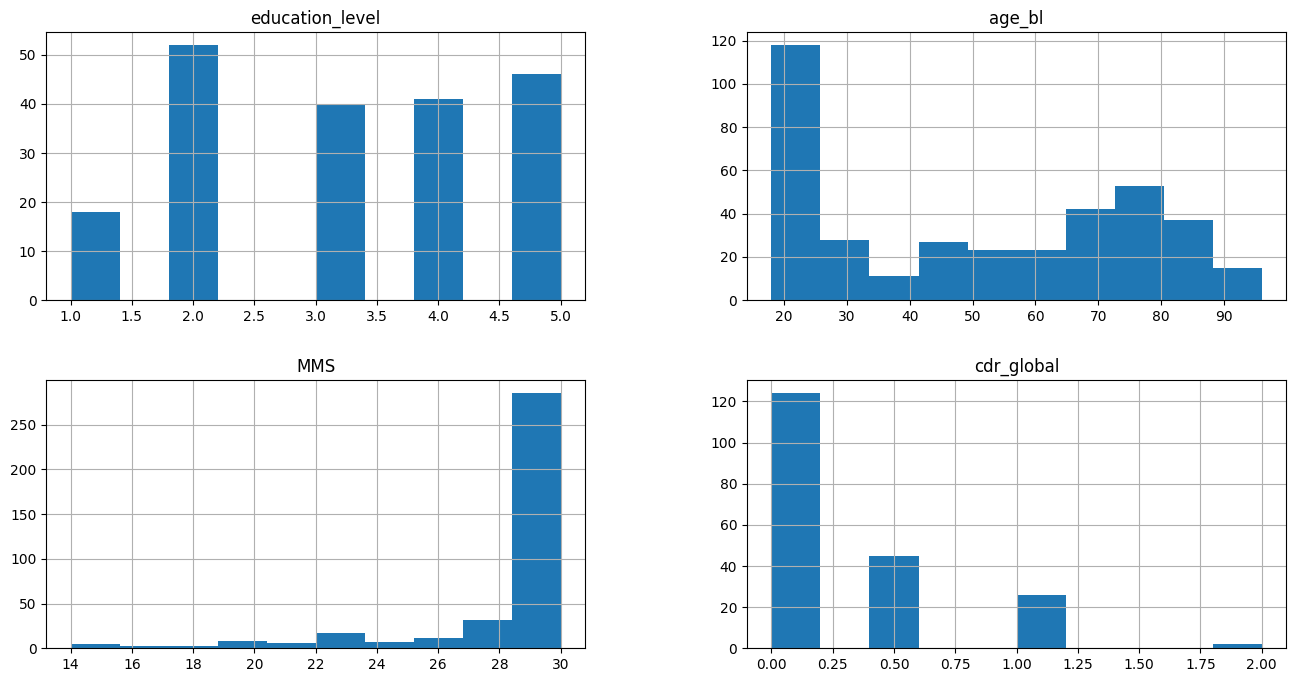

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:
class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckBlock3D(nn.Module):
    expansion = 4  # ResNet-50 uses an expansion factor of 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv3 = nn.Conv3d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = F.leaky_relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out)
        return out

class CustomResNet3D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(CustomResNet3D, self).__init__()
        self.in_channels = 8  # This initial number of channels must be carefully set according to the input and model structure

        self.conv1 = nn.Conv3d(1, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_channels)
        self.layer1 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * block.expansion, num_classes)  # Adjust output dimensions according to the last layer and the expansion factor

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool3d(x, (1, 1, 1))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


In [ ]:
import torch.nn as nn

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    train_best_loss = np.inf
    losses = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        count = 0

        for data in train_loader:
            images, labels = data['image'].cuda(), data['label'].cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        train_loss = total_loss / count
        losses['train'].append(train_loss)

        # Validation loss
        model.eval()
        total_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data['image'].cuda(), data['label'].cuda()
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                val_count += 1

        val_loss = total_val_loss / val_count
        losses['val'].append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

        if val_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = val_loss

    return best_model, losses

def plot_losses_per_lr(losses_dict):
    """
    Plots training and validation losses for each learning rate in separate graphs.

    Args:
        losses_dict: Dictionary where key is the learning rate and value is another dict
                     containing 'train' and 'val' losses lists.
    """
    for lr, losses in losses_dict.items():
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], label='Training Loss', color='blue')
        plt.title(f'Training Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(losses['val'], label='Validation Loss', color='red')
        plt.title(f'Validation Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

def plot_separate_losses(loss_history):
    """
    Function to plot training and validation losses on separate graphs for the best performing model.

    Args:
        loss_history: (dict) containing lists of training and validation losses
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss', color='blue')
    plt.title('Training Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['val'], label='Validation Loss', color='red')
    plt.title('Validation Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def display_confusion_matrix(conf_matrix):
    """
    Displays the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix: (numpy array) the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Best Model')
    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.5034, Val loss = 9.8947
Epoch 1: Train loss = 1.3582, Val loss = 9.0762
Epoch 2: Train loss = 1.2786, Val loss = 7.8871
Epoch 3: Train loss = 1.2352, Val loss = 9.4139
Epoch 4: Train loss = 1.4516, Val loss = 7.7524
Epoch 5: Train loss = 1.3420, Val loss = 25.0995
Epoch 6: Train loss = 1.0932, Val loss = 8.5984
Epoch 7: Train loss = 1.0339, Val loss = 10.1896
Epoch 8: Train loss = 1.0759, Val loss = 7.8236
Epoch 9: Train loss = 1.2680, Val loss = 9.9437
Epoch 10: Train loss = 1.0015, Val loss = 8.4122
Epoch 11: Train loss = 1.1569, Val loss = 8.4620
Epoch 12: Train loss = 1.0398, Val loss = 9.2735
Epoch 13: Train loss = 0.9903, Val loss = 9.3125
Epoch 14: Train loss = 1.0394, Val loss = 10.7076
Epoch 15: Train loss = 1.0389, Val loss = 13.1927
Epoch 16: Train loss = 1.1962, Val loss = 7.7576
Epoch 17: Train loss = 1.0001, Val loss = 8.7423
Epoch 18: Train loss = 1.0362, Val loss = 8.5510
Epoch 19: Train loss = 0.8514, Val loss = 9.1657
Epoch 20: Train loss = 1.1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[56  6]
 [ 4 11]]


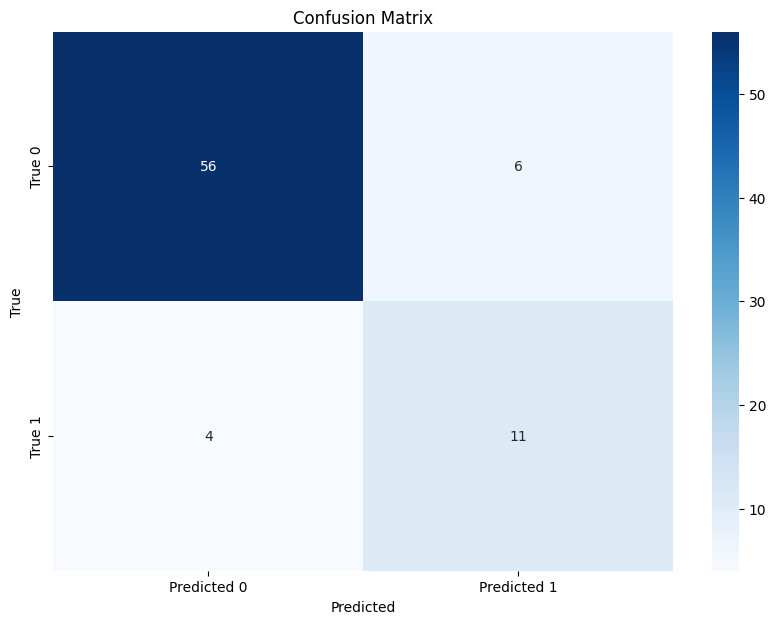

Learning Rate: 0.001 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.7917, Val loss = 39.9556
Epoch 1: Train loss = 1.4192, Val loss = 5.9831
Epoch 2: Train loss = 1.1997, Val loss = 10.6039
Epoch 3: Train loss = 1.0570, Val loss = 7.3504
Epoch 4: Train loss = 0.6281, Val loss = 10.6169
Epoch 5: Train loss = 0.9205, Val loss = 12.5543
Epoch 6: Train loss = 1.1674, Val loss = 9.7956
Epoch 7: Train loss = 0.7090, Val loss = 14.2205
Epoch 8: Train loss = 0.5521, Val loss = 8.0898
Epoch 9: Train loss = 0.6340, Val loss = 8.8620
Epoch 10: Train loss = 0.7374, Val loss = 7.8419
Epoch 11: Train loss = 0.3150, Val loss = 9.3167
Epoch 12: Train loss = 0.1491, Val loss = 19.5279
Epoch 13: Train loss = 0.6376, Val loss = 56.3305
Epoch 14: Train loss = 0.7237, Val loss = 14.2000
Epoch 15: Train loss = 0.8128, Val loss = 24.3522
Epoch 16: Train loss = 0.5724, Val loss = 8.0980
Epoch 17: Train loss = 0.3003, Val loss = 10.4530
Epoch 18: Train loss = 0.3190, Val loss = 8.2436
Epoch 19: Train loss = 0.3721, Val loss = 8.0316
Epoch 20: Train loss

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[57  5]
 [ 2 13]]


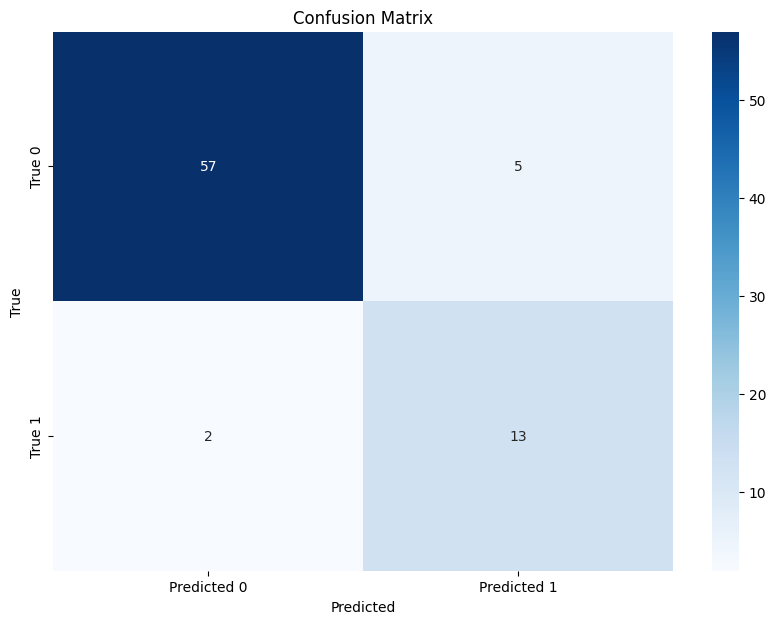

Learning Rate: 0.0005 - Validation Accuracy: 0.9090909090909091


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.7363, Val loss = 8.2979
Epoch 1: Train loss = 1.2838, Val loss = 11.9188
Epoch 2: Train loss = 1.0955, Val loss = 11.1523
Epoch 3: Train loss = 0.9370, Val loss = 8.3622
Epoch 4: Train loss = 0.8182, Val loss = 8.3770
Epoch 5: Train loss = 0.6844, Val loss = 10.1781
Epoch 6: Train loss = 0.4541, Val loss = 10.3829
Epoch 7: Train loss = 0.2942, Val loss = 11.9359
Epoch 8: Train loss = 0.2053, Val loss = 10.0700
Epoch 9: Train loss = 0.3040, Val loss = 13.8786
Epoch 10: Train loss = 0.2851, Val loss = 9.4544
Epoch 11: Train loss = 0.3049, Val loss = 10.5806
Epoch 12: Train loss = 0.2220, Val loss = 15.3710
Epoch 13: Train loss = 0.2659, Val loss = 11.9833
Epoch 14: Train loss = 0.2509, Val loss = 18.0320
Epoch 15: Train loss = 0.2452, Val loss = 11.4617
Epoch 16: Train loss = 0.2110, Val loss = 20.4146
Epoch 17: Train loss = 0.1818, Val loss = 10.2351
Epoch 18: Train loss = 0.1367, Val loss = 10.7654
Epoch 19: Train loss = 0.1519, Val loss = 13.1157
Epoch 20: Trai

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[61  1]
 [ 7  8]]


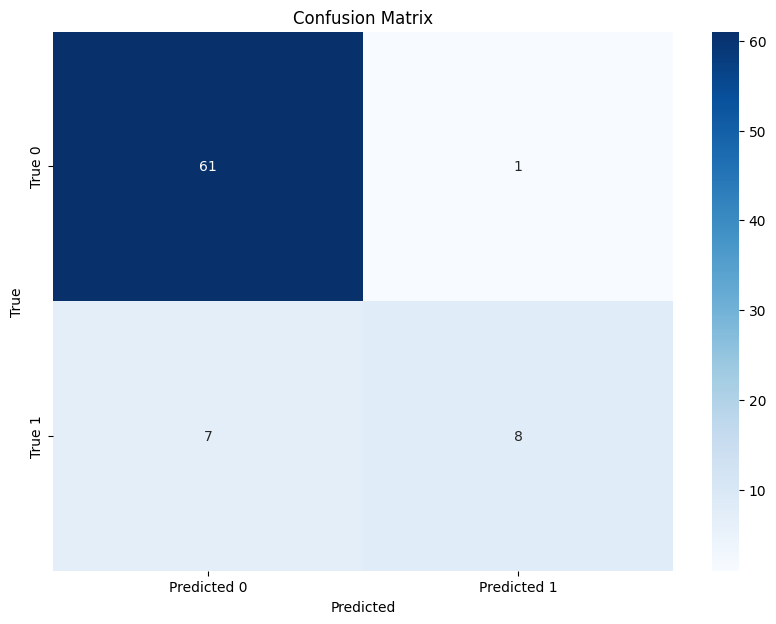

Learning Rate: 0.0001 - Validation Accuracy: 0.8961038961038961


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 3.3065, Val loss = 13.5234
Epoch 1: Train loss = 1.4616, Val loss = 8.6179
Epoch 2: Train loss = 1.1581, Val loss = 8.6958
Epoch 3: Train loss = 1.0611, Val loss = 12.1492
Epoch 4: Train loss = 1.0883, Val loss = 9.2709
Epoch 5: Train loss = 0.6823, Val loss = 9.0474
Epoch 6: Train loss = 0.6423, Val loss = 12.1912
Epoch 7: Train loss = 0.6103, Val loss = 9.6518
Epoch 8: Train loss = 0.6311, Val loss = 8.9086
Epoch 9: Train loss = 0.6803, Val loss = 9.7022
Epoch 10: Train loss = 0.6976, Val loss = 11.1113
Epoch 11: Train loss = 0.4799, Val loss = 9.0394
Epoch 12: Train loss = 0.6850, Val loss = 10.2722
Epoch 13: Train loss = 0.3751, Val loss = 8.4665
Epoch 14: Train loss = 0.5453, Val loss = 9.1353
Epoch 15: Train loss = 0.2494, Val loss = 8.9117
Epoch 16: Train loss = 0.3118, Val loss = 10.2834
Epoch 17: Train loss = 0.3317, Val loss = 10.8079
Epoch 18: Train loss = 0.3689, Val loss = 10.8517
Epoch 19: Train loss = 0.1935, Val loss = 10.3846
Epoch 20: Train loss 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 5 10]]


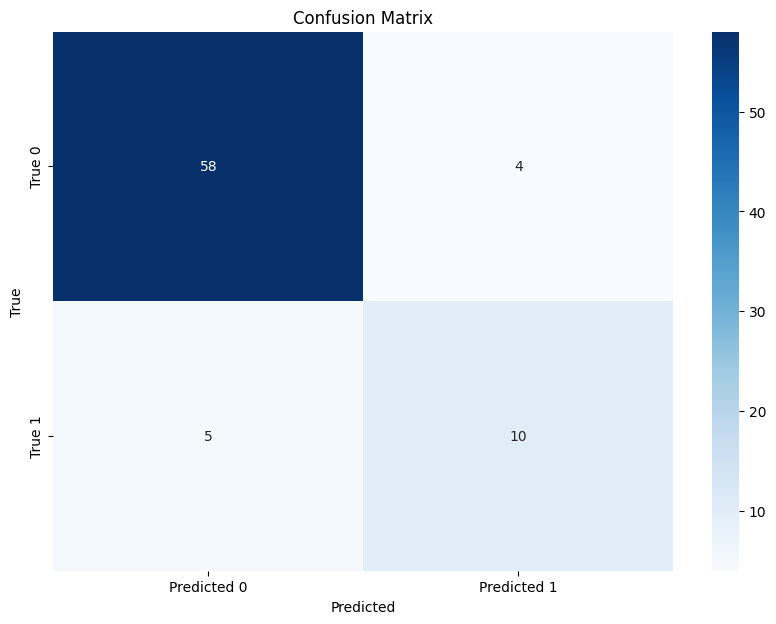

Learning Rate: 5e-05 - Validation Accuracy: 0.8831168831168831


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 6.0503, Val loss = 32.6956
Epoch 1: Train loss = 4.6785, Val loss = 25.5469
Epoch 2: Train loss = 3.5911, Val loss = 19.5714
Epoch 3: Train loss = 2.8003, Val loss = 15.9605
Epoch 4: Train loss = 2.3207, Val loss = 13.9123
Epoch 5: Train loss = 2.0208, Val loss = 12.7615
Epoch 6: Train loss = 1.8200, Val loss = 11.7330
Epoch 7: Train loss = 1.7055, Val loss = 11.2970
Epoch 8: Train loss = 1.5266, Val loss = 11.3964
Epoch 9: Train loss = 1.3801, Val loss = 10.9733
Epoch 10: Train loss = 1.3451, Val loss = 11.2047
Epoch 11: Train loss = 1.0943, Val loss = 11.4187
Epoch 12: Train loss = 1.0703, Val loss = 11.8874
Epoch 13: Train loss = 1.0091, Val loss = 11.6167
Epoch 14: Train loss = 0.8245, Val loss = 11.7545
Epoch 15: Train loss = 0.7344, Val loss = 12.3339
Epoch 16: Train loss = 0.6045, Val loss = 12.7659
Epoch 17: Train loss = 0.5990, Val loss = 11.8922
Epoch 18: Train loss = 0.7613, Val loss = 12.4199
Epoch 19: Train loss = 0.4227, Val loss = 13.5805
Epoch 20: 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 7  8]]


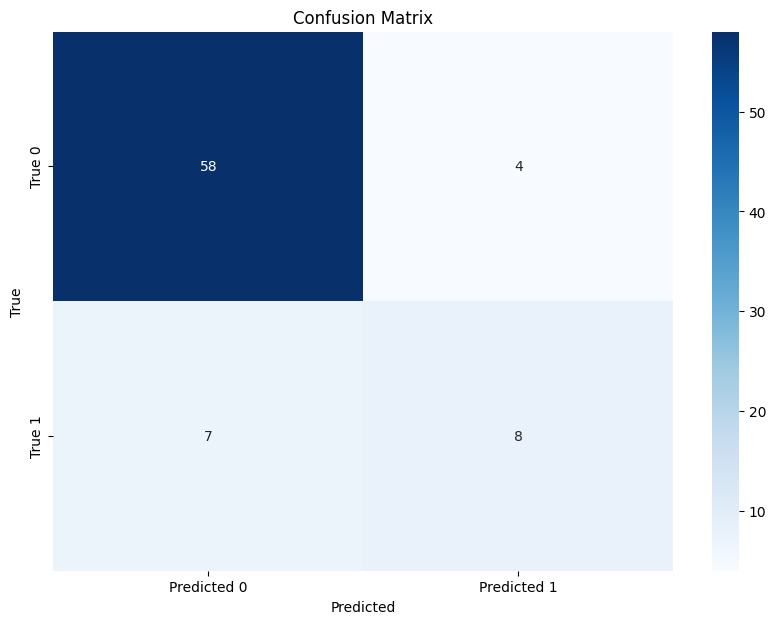

Learning Rate: 1e-05 - Validation Accuracy: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 4.1304, Val loss = 25.8941
Epoch 1: Train loss = 4.0139, Val loss = 25.1735
Epoch 2: Train loss = 3.9041, Val loss = 24.4177
Epoch 3: Train loss = 3.8027, Val loss = 23.9852
Epoch 4: Train loss = 3.7313, Val loss = 23.1757
Epoch 5: Train loss = 3.6273, Val loss = 22.7597
Epoch 6: Train loss = 3.5059, Val loss = 22.1062
Epoch 7: Train loss = 3.4552, Val loss = 21.7713
Epoch 8: Train loss = 3.3692, Val loss = 21.1188
Epoch 9: Train loss = 3.2633, Val loss = 20.5692
Epoch 10: Train loss = 3.2001, Val loss = 20.0270
Epoch 11: Train loss = 3.1245, Val loss = 19.6800
Epoch 12: Train loss = 3.0362, Val loss = 19.3899
Epoch 13: Train loss = 2.9856, Val loss = 18.7702
Epoch 14: Train loss = 2.9172, Val loss = 18.4256
Epoch 15: Train loss = 2.8648, Val loss = 18.1450
Epoch 16: Train loss = 2.7796, Val loss = 17.6577
Epoch 17: Train loss = 2.7150, Val loss = 17.1676
Epoch 18: Train loss = 2.6774, Val loss = 16.7166
Epoch 19: Train loss = 2.6158, Val loss = 16.7332
Epoch 20: 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[61  1]
 [ 9  6]]


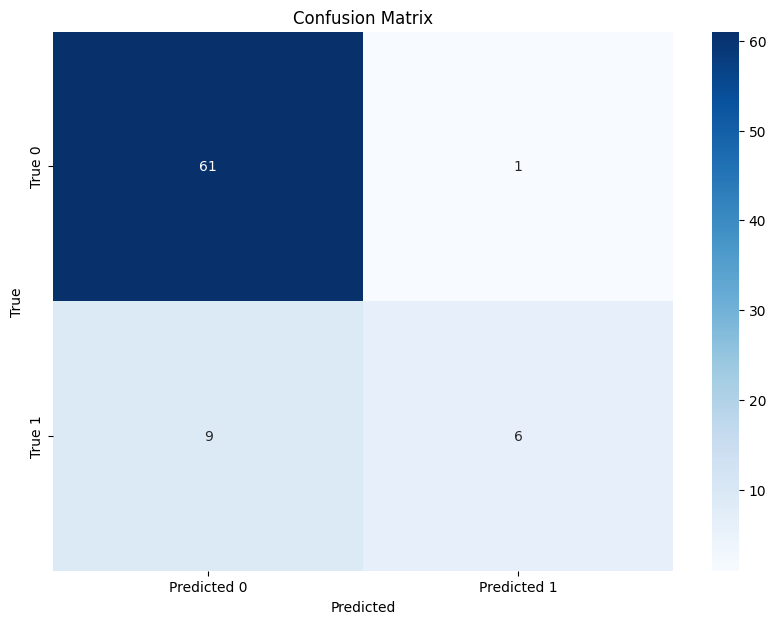

Learning Rate: 1e-06 - Validation Accuracy: 0.8701298701298701


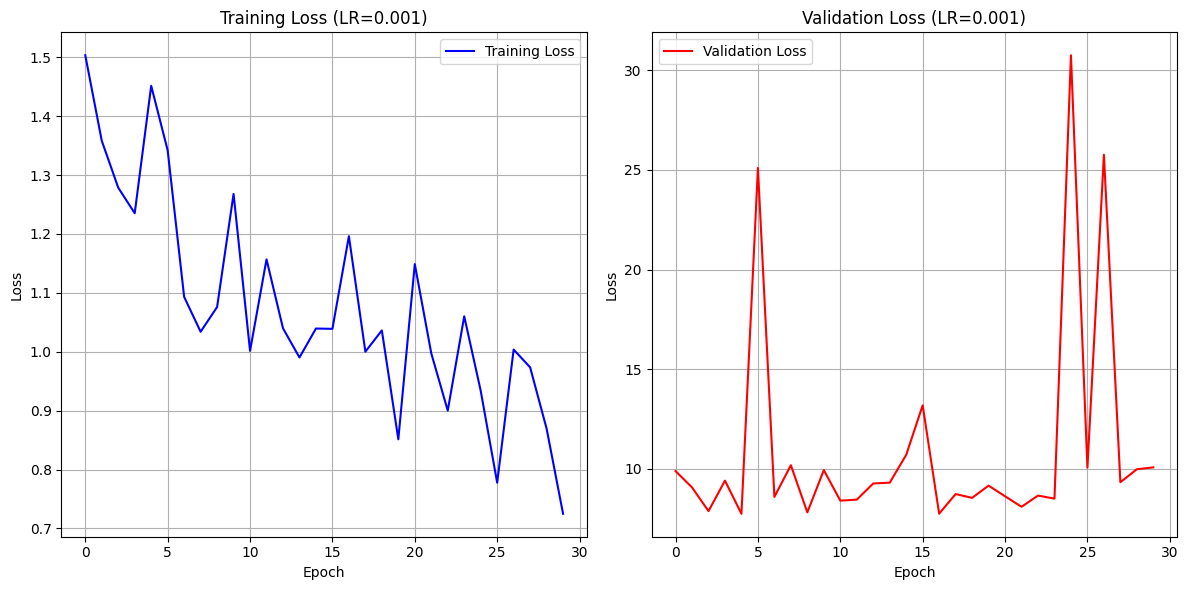

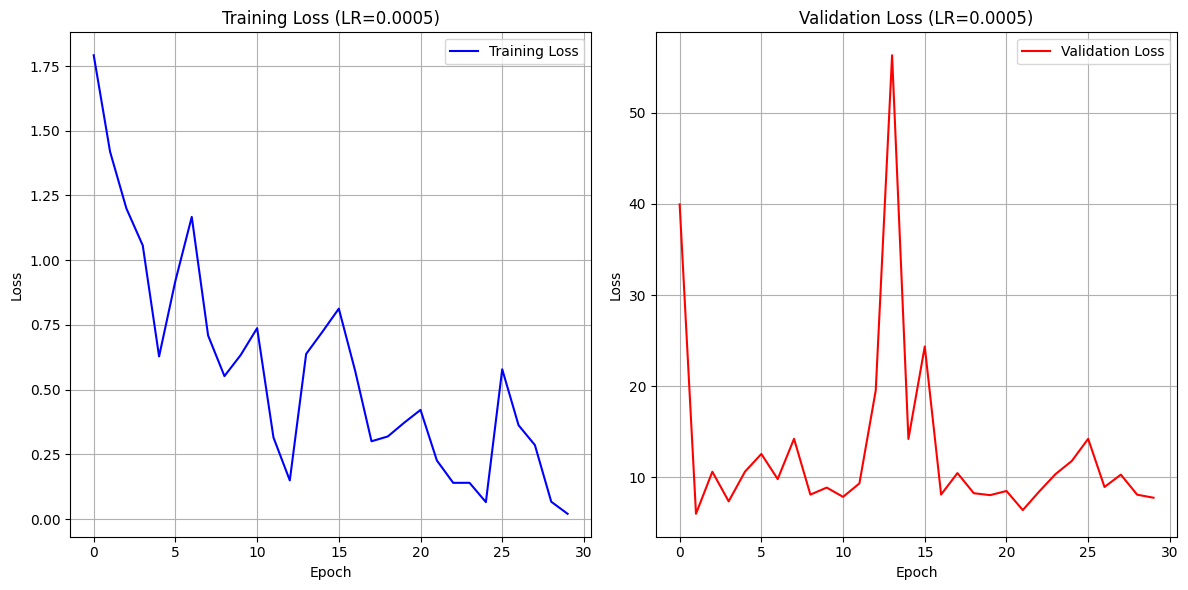

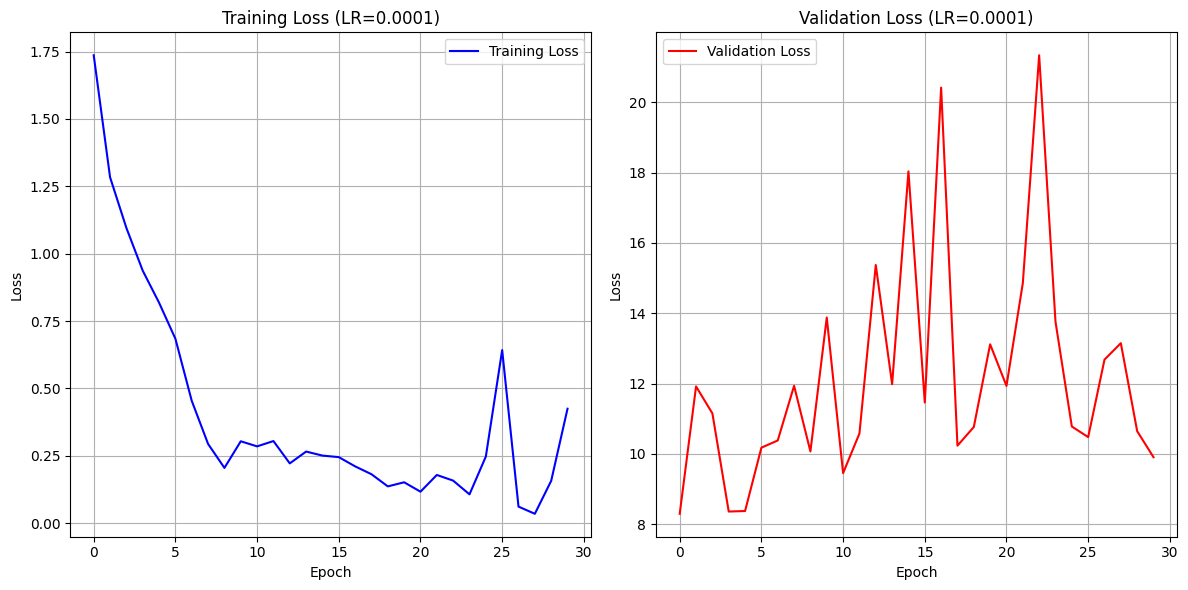

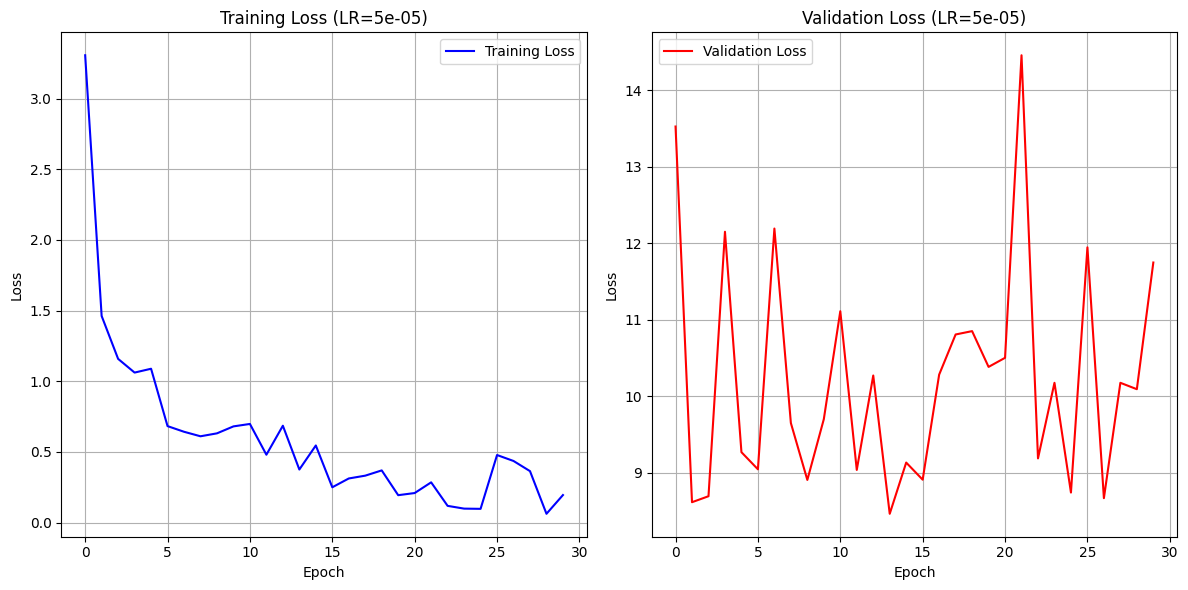

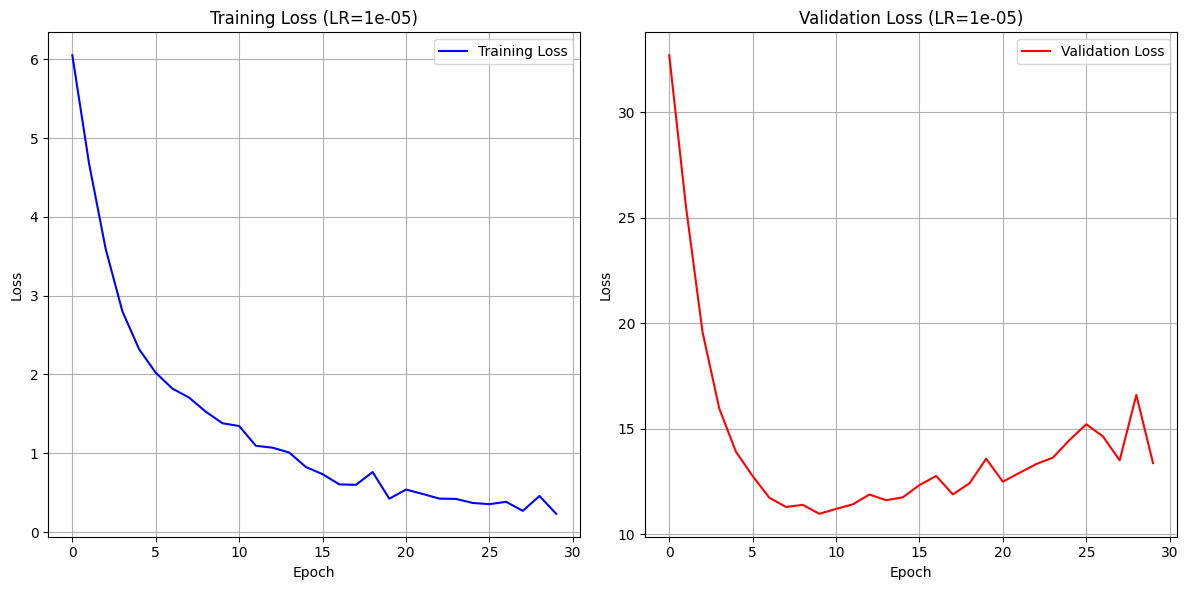

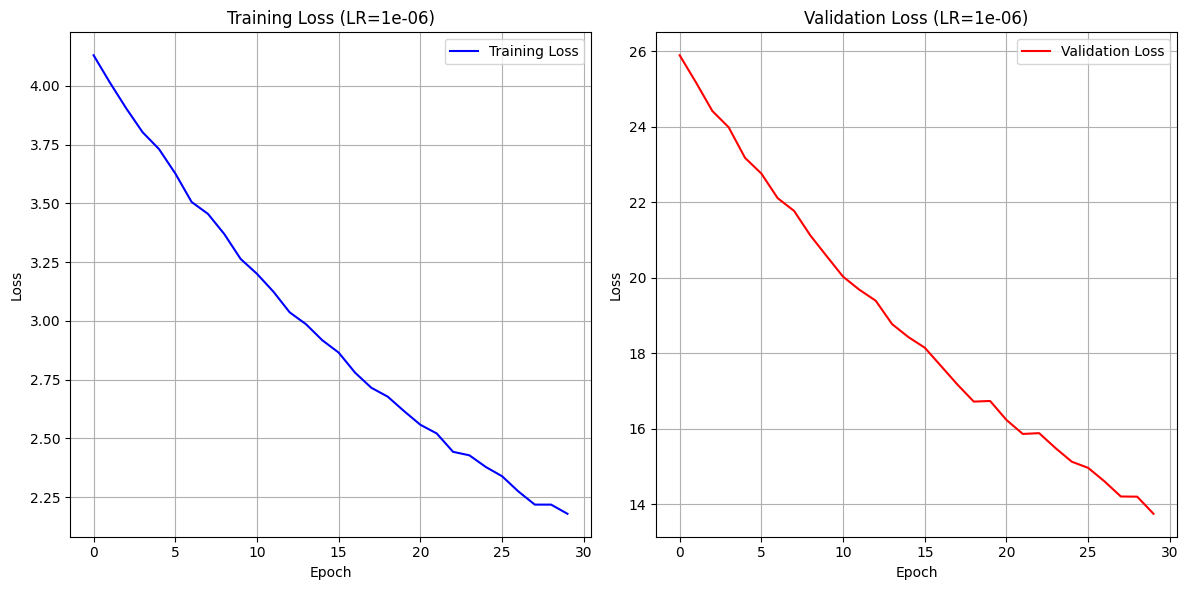

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomResNet3D(BottleneckBlock3D, [3, 4, 6, 3], num_classes=2).cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 3.6995, Val loss = 22.7500
Epoch 1: Train loss = 3.2277, Val loss = 18.8202
Epoch 2: Train loss = 2.8845, Val loss = 16.7928
Epoch 3: Train loss = 2.5862, Val loss = 15.7019
Epoch 4: Train loss = 2.3476, Val loss = 13.7895
Epoch 5: Train loss = 2.1891, Val loss = 13.2104
Epoch 6: Train loss = 2.0284, Val loss = 12.7656
Epoch 7: Train loss = 1.9500, Val loss = 11.8396
Epoch 8: Train loss = 1.8102, Val loss = 11.4150
Epoch 9: Train loss = 1.7534, Val loss = 11.2469
Epoch 10: Train loss = 1.6884, Val loss = 11.5581
Epoch 11: Train loss = 1.6978, Val loss = 10.6052
Epoch 12: Train loss = 1.5854, Val loss = 10.7622
Epoch 13: Train loss = 1.5276, Val loss = 10.7113
Epoch 14: Train loss = 1.4807, Val loss = 10.1779
Epoch 15: Train loss = 1.4657, Val loss = 9.9432
Epoch 16: Train loss = 1.4466, Val loss = 9.7174
Epoch 17: Train loss = 1.4491, Val loss = 8.7552
Epoch 18: Train loss = 1.4886, Val loss = 9.5029
Epoch 19: Train loss = 1.4487, Val loss = 9.1604
Epoch 20: Train

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[57  5]
 [ 5 10]]


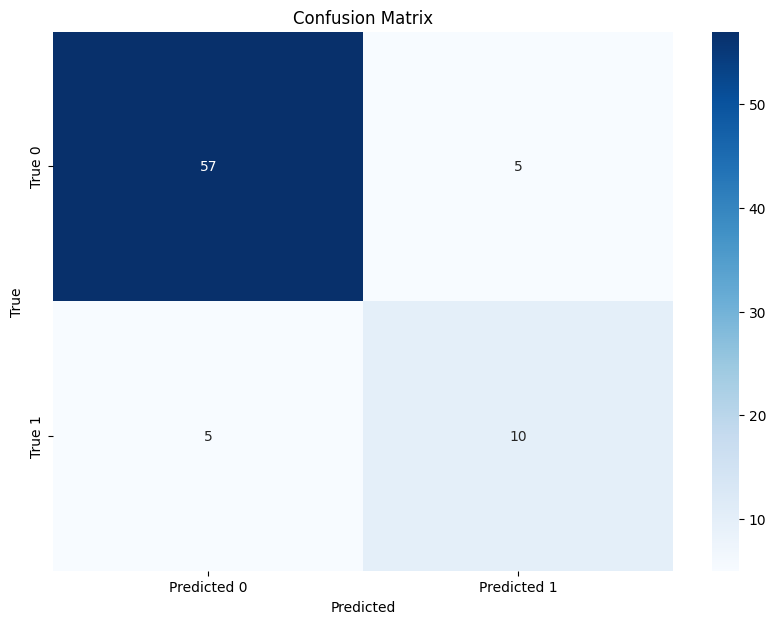

Learning Rate: 5e-06 - Validation Accuracy: 0.8701298701298701


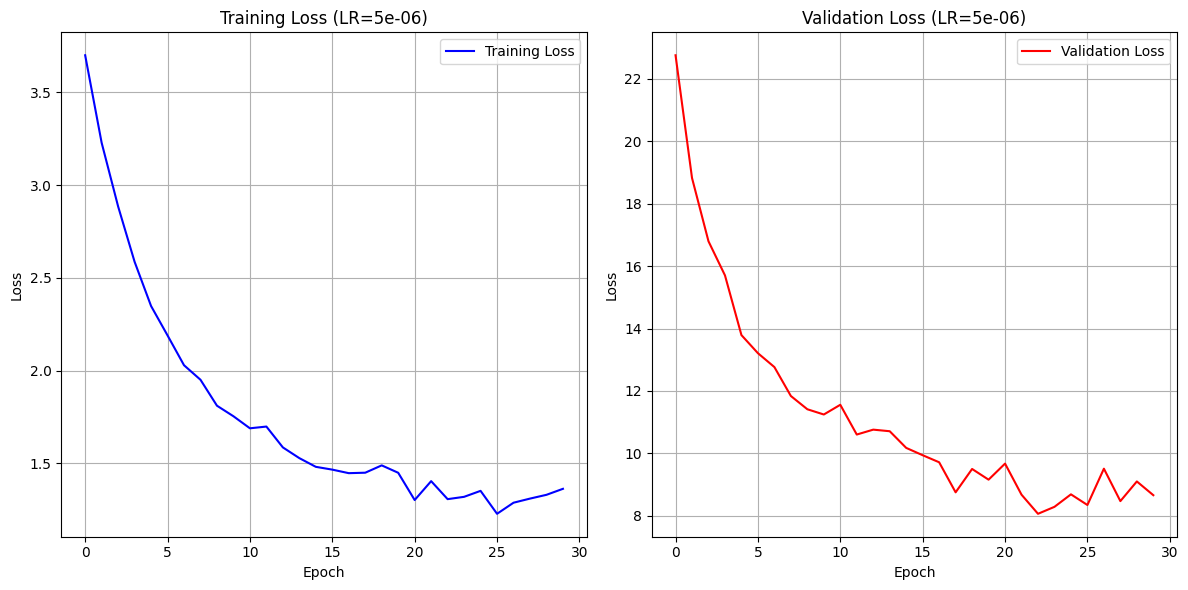

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = 5e-6
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomResNet3D(BottleneckBlock3D, [3, 4, 6, 3], num_classes=2).cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)